### Recursive least squares

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader

np.set_printoptions(suppress=True)

### Example 1: Copper

In [3]:
print(sm.datasets.copper.DESCRLONG)
dta=sm.datasets.copper.load_pandas().data
dta.index=pd.date_range('1951-01-01', '1975-01-01', freq='AS')
endog=dta['WORLDCONSUMPTION']

# To the regressors in the dataset, we add a columns of ones for an intercept
exog=sm.add_constant(dta[['COPPERPRICE', 'INCOMEINDEX', 'ALUMPRICE', 'INVENTORYINDEX']])

This data describes the world copper market from 1951 through 1975.  In an
example, in Gill, the outcome variable (of a 2 stage estimation) is the world
consumption of copper for the 25 years.  The explanatory variables are the
world consumption of copper in 1000 metric tons, the constant dollar adjusted
price of copper, the price of a substitute, aluminum, an index of real per
capita income base 1970, an annual measure of manufacturer inventory change,
and a time trend.



In [4]:
dta.head()

,WORLDCONSUMPTION,COPPERPRICE,INCOMEINDEX,ALUMPRICE,INVENTORYINDEX,TIME
1951-01-01,3173.0,26.56,0.70,19.76,0.98,1.0
1952-01-01,3281.1,27.31,0.71,20.78,1.04,2.0
1953-01-01,3135.7,32.95,0.72,22.55,1.05,3.0
1954-01-01,3359.1,33.90,0.70,23.06,0.97,4.0
1955-01-01,3755.1,42.70,0.74,24.93,1.02,5.0


In [5]:
exog.head()

,const,COPPERPRICE,INCOMEINDEX,ALUMPRICE,INVENTORYINDEX
1951-01-01,1.0,26.56,0.70,19.76,0.98
1952-01-01,1.0,27.31,0.71,20.78,1.04
1953-01-01,1.0,32.95,0.72,22.55,1.05
1954-01-01,1.0,33.90,0.70,23.06,0.97
1955-01-01,1.0,42.70,0.74,24.93,1.02


In [6]:
endog.head()

1951-01-01    3173.0
1952-01-01    3281.1
1953-01-01    3135.7
1954-01-01    3359.1
1955-01-01    3755.1
Freq: AS-JAN, Name: WORLDCONSUMPTION, dtype: float64

In [7]:
mod=sm.RecursiveLS(endog, exog)
res=mod.fit()
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:       WORLDCONSUMPTION   No. Observations:                   25
Model:                    RecursiveLS   Log Likelihood                -153.737
Date:                Tue, 01 Jan 2019   AIC                            317.474
Time:                        22:26:05   BIC                            323.568
Sample:                    01-01-1951   HQIC                           319.164
                         - 01-01-1975                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -6513.9926   2367.656     -2.751      0.006   -1.12e+04   -1873.472
COPPERPRICE      -13.6553     15.035     -0.908      0.364     -43.123      15.812
INCOMEINDEX     1.209e+04    762.592

[    2.88890056     4.94425555  1505.2705786   1856.55228281
  1597.9741118   2171.97840966  -889.39020347   122.17036038
 -4184.27521999 -6242.7312071  -7111.45819908 -6400.38438412
 -6090.45569381 -7154.96712846 -6290.92468562 -5805.25759065
 -6219.31805424 -6684.49666282 -6430.13849571 -5957.57771076
 -6407.06003686 -5983.49315595 -5224.7172207  -5286.62180288
 -6513.99259409]


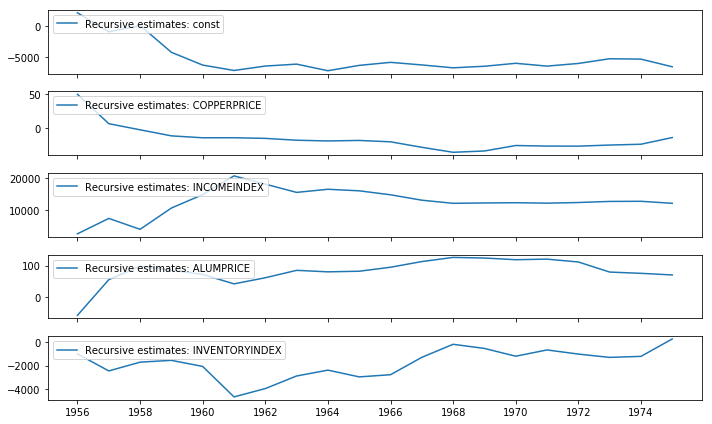

In [8]:
print(res.recursive_coefficients.filtered[0])
res.plot_recursive_coefficient(range(mod.k_exog), alpha=None,figsize=(10,6));

[ 0.2781906   0.51898719  1.0539959   1.94931158  2.44814403  3.37264225
  3.04779699  2.47333119  2.96188541  2.58228688  1.49433914 -0.50008446
 -2.01112588 -1.75503207 -0.90603879 -1.41035932 -0.80383113  0.71254056
  1.19151854 -0.93369946]


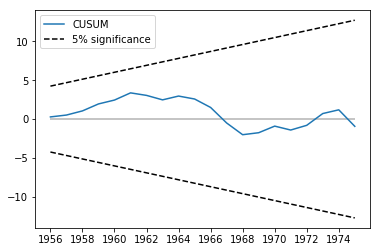

In [9]:
print(res.cusum)
fig=res.plot_cusum();

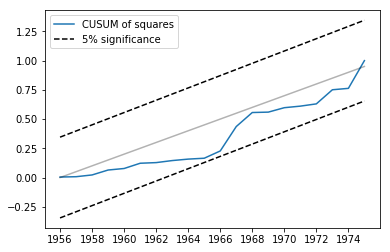

In [10]:
res.plot_cusum_squares();

### Quantity theory of money

In [11]:
start='1959-12-01'
end='2015-01-01'
m2=DataReader('M2SL', 'fred', start=start, end=end)
cpi=DataReader('CPIAUCSL', 'fred', start=start, end=end)

In [13]:
def ewma(series, beta, n_window):
    nobs=len(series)
    scalar=(1-beta)/(1+beta)
    ma=[]
    k=np.arange(n_window, 0, -1)
    weights=np.r_[beta**k, 1, beta**k[::-1]]
    for t in range(n_window, nobs-n_window):
        window=series.iloc[t-n_window: t+n_window+1].values
        ma.append(scalar*np.sum(weights*window))
    return pd.Series(ma, name=series.name, index=series.iloc[n_window:-n_window].index)

m2_ewma=ewma(np.log(m2['M2SL'].resample('QS').mean()).diff().iloc[1:], 0.95, 10*4)
cpi_ewma=ewma(np.log(cpi['CPIAUCSL'].resample('QS').mean()).diff().iloc[1:], 0.95, 10*4)

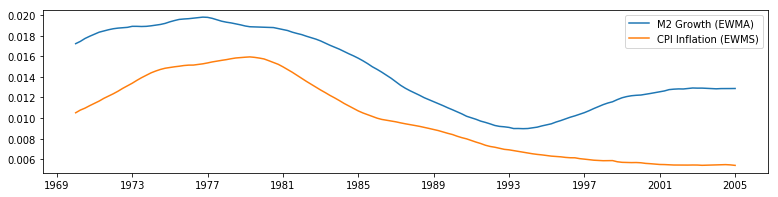

In [14]:
fig, ax=plt.subplots(figsize=(13,3))
ax.plot(m2_ewma, label='M2 Growth (EWMA)')
ax.plot(cpi_ewma, label='CPI Inflation (EWMS)')
ax.legend();

In [15]:
endog=cpi_ewma
exog=sm.add_constant(m2_ewma)
exog.columns=['const', 'M2']
mod=sm.RecursiveLS(endog, exog)
res=mod.fit()
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:               CPIAUCSL   No. Observations:                  141
Model:                    RecursiveLS   Log Likelihood                 686.268
Date:                Tue, 01 Jan 2019   AIC                          -1368.536
Time:                        22:53:28   BIC                          -1362.639
Sample:                    01-01-1970   HQIC                         -1366.140
                         - 01-01-2005                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.001     -5.935      0.000      -0.004      -0.002
M2             0.9098      0.037     24.597      0.000       0.837       0.982
Ljung-Box (Q):                     1857.32   Jarque-

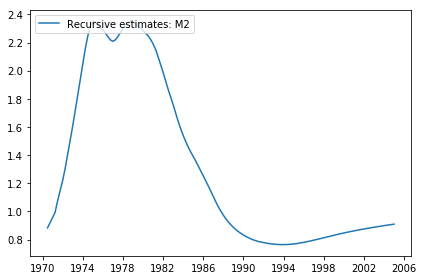

In [16]:
res.plot_recursive_coefficient(1, alpha=None);

The CUSUM plot now shows substantial deviation at the 5% level, suggesting a rehection of the null hypothesis of parameter stability.

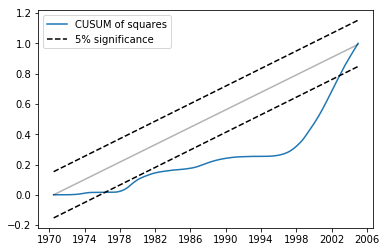

In [17]:
res.plot_cusum_squares();

Similarly, the CUSUM of squares shows substantial deviation at the 5% level, also suggesting a rehection of the null hypothesis of parameter stability.